**<h1><center> VECTOR SPACE MODEL + BM25 </center></h1>**

#Thông tin thành viên


1.   Lê Tấn Lộc - MSSV: 20521546
2.   Lê Trần Hữu Phước - MSSV: 20521775
3.   Nguyễn Thị Ngọc Nga - MSSV: 20521641



# Load dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#đặt đường dẫn dữ liệu
path_corpus = '/content/drive/MyDrive/CS419.N11.KHCL/Cranfield'
path_query = '/content/drive/MyDrive/CS419.N11.KHCL/TEST/query.txt'
path_relevance = '/content/drive/MyDrive/CS419.N11.KHCL/TEST/RES'

Đọc dữ liệu Cranfield vào corpus

In [3]:
corpus = []
for path in range(1400):
  with open(path_corpus +'/'+ str(path+1) + '.txt', 'r', encoding ='UTF-8') as f:
    temp = f.readline()
    corpus.append(temp)
print(corpus[0])

experimental investigation of the aerodynamics of a wing in a slipstream . an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem . the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary layer control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory . an empirical evaluation of the destalling effects was made for the specific configuration of the experiment . 


Load query

In [4]:
queries = []
with open(path_query, 'r', encoding='UTF-8') as f:
  values = f.readlines()
  for item in values:
    queries.append(item.split('\t')[1].strip('\n'))
print(queries[0])

what similarity laws must be obeyed when constructing aeroelastic models of heated high speed aircraft .


Load relevant documents

In [5]:
relevance = {}
for i in range(225):
  with open(path_relevance + '/' + str(i+1) + '.txt', 'r', encoding='UTF-8') as f:
    temp = f.readlines()
    num_query = temp[0].split()[0]
    relevant = []
    for i in range(len(temp)):
      value = temp[i].split()[1]
      value = value.split('\t')[0]
      relevant.append(int(value))

    relevance[num_query] = sorted(relevant)
print(relevance['1'])

[12, 13, 14, 15, 29, 30, 31, 37, 51, 52, 56, 57, 66, 95, 102, 142, 184, 185, 195, 378, 462, 486, 497, 858, 859, 875, 876, 879, 880]


# Stemming Function

In [6]:
import sys

class My_Stemmer:

    def __init__(self):
        self.b = ""  # buffer for word to be stemmed
        self.k = 0
        self.k0 = 0
        self.j = 0   # j is a general offset into the string

    def cons(self, i):
        if self.b[i] == 'a' or self.b[i] == 'e' or self.b[i] == 'i' or self.b[i] == 'o' or self.b[i] == 'u':
            return 0
        if self.b[i] == 'y':
            if i == self.k0:
                return 1
            else:
                return (not self.cons(i - 1))
        return 1

    def m(self):
        n = 0
        i = self.k0
        while 1:
            if i > self.j:
                return n
            if not self.cons(i):
                break
            i = i + 1
        i = i + 1
        while 1:
            while 1:
                if i > self.j:
                    return n
                if self.cons(i):
                    break
                i = i + 1
            i = i + 1
            n = n + 1
            while 1:
                if i > self.j:
                    return n
                if not self.cons(i):
                    break
                i = i + 1
            i = i + 1

    def vowelinstem(self):
        """vowelinstem() is TRUE <=> k0,...j contains a vowel"""
        for i in range(self.k0, self.j + 1):
            if not self.cons(i):
                return 1
        return 0

    def doublec(self, j):
        """doublec(j) is TRUE <=> j,(j-1) contain a double consonant."""
        if j < (self.k0 + 1):
            return 0
        if (self.b[j] != self.b[j-1]):
            return 0
        return self.cons(j)

    def cvc(self, i):
        if i < (self.k0 + 2) or not self.cons(i) or self.cons(i-1) or not self.cons(i-2):
            return 0
        ch = self.b[i]
        if ch == 'w' or ch == 'x' or ch == 'y':
            return 0
        return 1

    def ends(self, s):
        """ends(s) is TRUE <=> k0,...k ends with the string s."""
        length = len(s)
        if s[length - 1] != self.b[self.k]: # tiny speed-up
            return 0
        if length > (self.k - self.k0 + 1):
            return 0
        if self.b[self.k-length+1:self.k+1] != s:
            return 0
        self.j = self.k - length
        return 1

    def setto(self, s):
        """setto(s) sets (j+1),...k to the characters in the string s, readjusting k."""
        length = len(s)
        self.b = self.b[:self.j+1] + s + self.b[self.j+length+1:]
        self.k = self.j + length

    def r(self, s):
        """r(s) is used further down."""
        if self.m() > 0:
            self.setto(s)

    def step1ab(self):
        if self.b[self.k] == 's':
            if self.ends("sses"):
                self.k = self.k - 2
            elif self.ends("ies"):
                self.setto("i")
            elif self.b[self.k - 1] != 's':
                self.k = self.k - 1
        if self.ends("eed"):
            if self.m() > 0:
                self.k = self.k - 1
        elif (self.ends("ed") or self.ends("ing")) and self.vowelinstem():
            self.k = self.j
            if self.ends("at"):   self.setto("ate")
            elif self.ends("bl"): self.setto("ble")
            elif self.ends("iz"): self.setto("ize")
            elif self.doublec(self.k):
                self.k = self.k - 1
                ch = self.b[self.k]
                if ch == 'l' or ch == 's' or ch == 'z':
                    self.k = self.k + 1
            elif (self.m() == 1 and self.cvc(self.k)):
                self.setto("e")

    def step1c(self):
        """step1c() turns terminal y to i when there is another vowel in the stem."""
        if (self.ends("y") and self.vowelinstem()):
            self.b = self.b[:self.k] + 'i' + self.b[self.k+1:]

    def step2(self):
        if self.b[self.k - 1] == 'a':
            if self.ends("ational"):   self.r("ate")
            elif self.ends("tional"):  self.r("tion")
        elif self.b[self.k - 1] == 'c':
            if self.ends("enci"):      self.r("ence")
            elif self.ends("anci"):    self.r("ance")
        elif self.b[self.k - 1] == 'e':
            if self.ends("izer"):      self.r("ize")
        elif self.b[self.k - 1] == 'l':
            if self.ends("bli"):       self.r("ble") # --DEPARTURE--
            # To match the published algorithm, replace this phrase with
            #   if self.ends("abli"):      self.r("able")
            elif self.ends("alli"):    self.r("al")
            elif self.ends("entli"):   self.r("ent")
            elif self.ends("eli"):     self.r("e")
            elif self.ends("ousli"):   self.r("ous")
        elif self.b[self.k - 1] == 'o':
            if self.ends("ization"):   self.r("ize")
            elif self.ends("ation"):   self.r("ate")
            elif self.ends("ator"):    self.r("ate")
        elif self.b[self.k - 1] == 's':
            if self.ends("alism"):     self.r("al")
            elif self.ends("iveness"): self.r("ive")
            elif self.ends("fulness"): self.r("ful")
            elif self.ends("ousness"): self.r("ous")
        elif self.b[self.k - 1] == 't':
            if self.ends("aliti"):     self.r("al")
            elif self.ends("iviti"):   self.r("ive")
            elif self.ends("biliti"):  self.r("ble")
        elif self.b[self.k - 1] == 'g': # --DEPARTURE--
            if self.ends("logi"):      self.r("log")
        # To match the published algorithm, delete this phrase

    def step3(self):
        """step3() dels with -ic-, -full, -ness etc. similar strategy to step2."""
        if self.b[self.k] == 'e':
            if self.ends("icate"):     self.r("ic")
            elif self.ends("ative"):   self.r("")
            elif self.ends("alize"):   self.r("al")
        elif self.b[self.k] == 'i':
            if self.ends("iciti"):     self.r("ic")
        elif self.b[self.k] == 'l':
            if self.ends("ical"):      self.r("ic")
            elif self.ends("ful"):     self.r("")
        elif self.b[self.k] == 's':
            if self.ends("ness"):      self.r("")

    def step4(self):
        """step4() takes off -ant, -ence etc., in context vcvc."""
        if self.b[self.k - 1] == 'a':
            if self.ends("al"): pass
            else: return
        elif self.b[self.k - 1] == 'c':
            if self.ends("ance"): pass
            elif self.ends("ence"): pass
            else: return
        elif self.b[self.k - 1] == 'e':
            if self.ends("er"): pass
            else: return
        elif self.b[self.k - 1] == 'i':
            if self.ends("ic"): pass
            else: return
        elif self.b[self.k - 1] == 'l':
            if self.ends("able"): pass
            elif self.ends("ible"): pass
            else: return
        elif self.b[self.k - 1] == 'n':
            if self.ends("ant"): pass
            elif self.ends("ement"): pass
            elif self.ends("ment"): pass
            elif self.ends("ent"): pass
            else: return
        elif self.b[self.k - 1] == 'o':
            if self.ends("ion") and (self.b[self.j] == 's' or self.b[self.j] == 't'): pass
            elif self.ends("ou"): pass
            # takes care of -ous
            else: return
        elif self.b[self.k - 1] == 's':
            if self.ends("ism"): pass
            else: return
        elif self.b[self.k - 1] == 't':
            if self.ends("ate"): pass
            elif self.ends("iti"): pass
            else: return
        elif self.b[self.k - 1] == 'u':
            if self.ends("ous"): pass
            else: return
        elif self.b[self.k - 1] == 'v':
            if self.ends("ive"): pass
            else: return
        elif self.b[self.k - 1] == 'z':
            if self.ends("ize"): pass
            else: return
        else:
            return
        if self.m() > 1:
            self.k = self.j

    def step5(self):
        """step5() removes a final -e if m() > 1, and changes -ll to -l if
        m() > 1.
        """
        self.j = self.k
        if self.b[self.k] == 'e':
            a = self.m()
            if a > 1 or (a == 1 and not self.cvc(self.k-1)):
                self.k = self.k - 1
        if self.b[self.k] == 'l' and self.doublec(self.k) and self.m() > 1:
            self.k = self.k -1

    def stem(self, p, i, j):
        # copy the parameters into statics
        self.b = p
        self.k = j
        self.k0 = i
        if self.k <= self.k0 + 1:
            return self.b # --DEPARTURE--

        # With this line, strings of length 1 or 2 don't go through the
        # stemming process, although no mention is made of this in the
        # published algorithm. Remove the line to match the published
        # algorithm.

        self.step1ab()
        self.step1c()
        self.step2()
        self.step3()
        self.step4()
        self.step5()
        return self.b[self.k0:self.k+1]

# Evaluation Function

In [7]:
import os
data_path = '/content/drive/MyDrive/CS419.N11.KHCL/TEST'
evaluate_path = os.path.join(data_path, 'RES')

In [8]:
class Evaluate:
    def __init__(self, evapath, predict, rank=False):
        self.dataLength = len(list(os.listdir(evapath)))
        self.predict = predict

        self.gold_standard = []
        self.load_relevant_doc()

        self.precision = []
        self.calculate_precision(rank)

        self.recall = []
        self.calculate_recall(rank)

    def load_relevant_doc(self):
        for i in range(self.dataLength):
            file_path = os.path.join(evaluate_path, str(i + 1) + '.txt')

            with open(file_path, 'r', encoding="utf-8") as file:
                data = []
                for line in file:
                    data.append(int(line.split()[1]))

                self.gold_standard.append(data)

    def calculate_precision(self, rank):
        if rank:
            for i in range(self.dataLength):
                p = []
                right = 0

                for index, res in enumerate(self.predict[i]):
                    if res in self.gold_standard[i]:
                        right += 1
                        p.append(right / (index + 1))

                self.precision.append(p)
        else:
            for i in range(self.dataLength):
                right = 0

                for res in self.predict[i]:
                    if res in self.gold_standard[i]:
                        right += 1

                self.precision.append(right / len(self.predict[i]))

    def calculate_recall(self, rank):
        if rank:
            for i in range(self.dataLength):
                r = []

                for j in range(len(self.precision[i])):
                    r.append((j + 1) / len(self.gold_standard[i]))

                self.recall.append(r)
        else:
            for i in range(self.dataLength):
                right = 0

                for res in self.predict[i]:
                    if res in self.gold_standard[i]:
                        right += 1

                self.recall.append(right / len(self.gold_standard[i]))


    def average(self, array):
        sum = 0
        count = 0
        for element in array:
            sum += element
            count += 1

        return sum / count if count else 0

    def find_P_from_R_inter(self, r, P, R):
        p = []
        for i in range(len(P)):
            if R[i] >= r:
                p.append(P[i])

        return max(p) if len(p) else 0

    def AP_no_inter(self):
        AP = []
        for res in (self.precision):
            AP.append(self.average(res))

        return AP

    def AP_inter(self):
        AP = []

        for i in range(self.dataLength):
            p = []

            for r in range(11):
                p.append(self.find_P_from_R_inter(r / 10, self.precision[i], self.recall[i]))

            AP.append(self.average(p))

        return AP

    def MAP(self, interpolate=False):
        if interpolate:
            AP = self.AP_inter()
        else:
            AP = self.AP_no_inter()

        return self.average(AP)

# Preprocessing

In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
!pip install num2words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=2db036b114293f4009594a69c04b17cd80a025e3fd7124aaea62042be7cb652e
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words


import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import re
import math


In [11]:
# Chuyển toàn bộ dữ liệu thành chữ thường
def convert_lower_case(data):
    return np.char.lower(data)

In [12]:
# Loại bỏ stopwords
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

In [13]:
# Loại bỏ dấu câu
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

In [14]:
# Loại bỏ dấu nháy đơn
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

In [100]:
# stemming
def stemming(data):
    # stemmer= PorterStemmer()
    
    stemmer = My_Stemmer()    # my_stemming
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
      # new_text = new_text + " " + stemmer.stem(w)
      
      new_text = new_text + " " + stemmer.stem(w,0,len(w)-1)   # my_stemming

    return new_text

In [16]:
# Chuyển số thành chữ
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

In [101]:
#preprocessing
def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data) #needed again as we need to stem the words
    data = remove_punctuation(data) #needed again as num2word is giving few hypens and commas fourty-one
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [102]:
processed_text = []
for text in corpus:
  processed_text.append(word_tokenize(str(preprocess(text))))

In [19]:
print(processed_text[0])

['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi', 'wing', 'propel', 'slipstream', 'made', 'order', 'determin', 'spanwis', 'distribut', 'lift', 'increas', 'due', 'slipstream', 'differ', 'angl', 'attack', 'wing', 'differ', 'free', 'stream', 'slipstream', 'veloc', 'ratio', 'result', 'intend', 'part', 'evalu', 'basi', 'differ', 'theoret', 'treatment', 'problem', 'compar', 'span', 'load', 'curv', 'togeth', 'support', 'evid', 'show', 'substanti', 'part', 'lift', 'increment', 'produc', 'slipstream', 'due', 'destal', 'boundari', 'layer', 'control', 'effect', 'integr', 'remain', 'lift', 'increment', 'subtract', 'destal', 'lift', 'found', 'agre', 'well', 'potenti', 'flow', 'theori', 'empir', 'evalu', 'destal', 'effect', 'made', 'specif', 'configur', 'experi']


# Vector Space Model

## Building Inverted Index

In [103]:
from collections import *
import time

term_doc = []

def make_unique(l):
    l = set(l) #remove Duplicates
    l = list(l) #convert to list again
    return l

def index1(l,d):
    occurences = {}
    for word in l:
        d = {}
        for i in range(len(processed_text)):
            temp = [j for j,val in enumerate(processed_text[i]) if val==word]
            if temp :
                d[i+1] = len(temp)
        occurences[word] = d
    return occurences


for doc in processed_text:
    for j in doc:
        term_doc.append(j)


term_doc = make_unique(term_doc)
posting_list = {}
start = time.time()
posting_list = index1(term_doc,posting_list)
end = time.time()

print("Inverted Index has been Built !")
print("Time of Building Inverted Index:\t", (end-start))

Inverted Index has been Built !
Time of Building Inverted Index:	 42.792232036590576


In [104]:
print(posting_list)

{'receiv': {44: 1, 172: 1, 317: 1, 453: 1, 532: 1, 585: 1, 589: 1, 845: 1, 1019: 1}, 'furnac': {120: 1}, 'channel': {33: 2, 34: 3, 112: 3, 206: 1, 270: 6, 338: 1, 351: 1, 387: 1, 417: 1, 491: 2, 624: 1, 939: 1, 941: 6, 966: 3, 1203: 1, 1221: 3, 1222: 2}, 'inaccuraci': {81: 1, 1033: 1, 1199: 1}, 'latitud': {619: 1, 621: 3}, 'forum': {6: 1, 91: 1}, 'hous': {993: 2}, 'layout': {184: 1, 1342: 2}, 'sens': {44: 1, 77: 1, 87: 1, 164: 1, 247: 1, 724: 1, 731: 1, 966: 1, 991: 1, 1127: 1, 1248: 1, 1343: 1}, 'opposit': {43: 1, 47: 1, 73: 1, 101: 1, 162: 1, 212: 1, 432: 1, 520: 1, 659: 1, 773: 1, 872: 1, 1065: 1, 1277: 3, 1282: 1, 1387: 1, 1392: 1}, 'solid': {13: 1, 73: 2, 90: 1, 97: 1, 119: 1, 169: 2, 181: 1, 240: 2, 244: 3, 266: 2, 344: 2, 452: 1, 480: 1, 486: 1, 518: 3, 542: 2, 560: 1, 584: 1, 586: 2, 672: 1, 773: 2, 800: 1, 873: 1, 968: 1, 978: 1, 981: 1, 1102: 2, 1142: 2, 1153: 1, 1173: 1, 1190: 2, 1223: 4, 1244: 2, 1292: 1, 1303: 1, 1326: 2, 1338: 1, 1340: 2, 1351: 1, 1373: 1, 1382: 2}, 'untr

In [105]:
import sys
sys.getsizeof(posting_list)

147552

In [106]:
print("Số lượng term được lựa chọn: ", len(term_doc))

Số lượng term được lựa chọn:  4416


In [24]:
with open('term.txt', 'w') as file:
  for item in term_doc:
    item = item + '\n'
    file.writelines(item)
file.close()

## Building TF-IDF

In [25]:
from math import log, pow, sqrt


#dictionaries to hold idf values for words in body 
idf = {}

#dictionaries to hold tf values for words in body for each document
tf = {}

def calc_tf_idf(tf,idf,org,N): 	
    for key,val in org.items():
        raw_tf = {}
        #idf value for token 'key'
        idf[key] = (log((float(N)/len(val.keys())),10))  #val.keys() - in how many titles the wor occurred
        for doc_key,doc_val in val.items():
            if doc_val>0:   #if the word is not in start (title words)
                #tf value for token 'key' and document 'doc_key'
                raw_tf[doc_key] = (1 + log((doc_val),10))
            else:
                raw_tf[doc_key] = 0
        tf[key] = raw_tf

def normalize_doc():
    norm = []
    for i in range(len(processed_text)):
        temp = []
        l = 0.0
        for word in processed_text[i]:
            if word not in temp:
                temp.append(word)
        
        # 1+log(tf); tf -> occurence of word in that document
        # calculating full document to a score
        for word in temp:
          l = l + pow(tf[word][i+1],2)
                
        l = sqrt(l)
        norm.append(l)
        # for word in temp:
        #   tf[word][i] = tf[word][i+1]/l
    return norm

In [26]:
#calculates tf-idf for post
calc_tf_idf(tf, idf, posting_list, len(processed_text))

#normalizes body for all documents
norm_doc = normalize_doc()

print("TF-IDF has been Built !")

TF-IDF has been Built !


In [27]:
print(tf['wing'])

{1: 1.4771212547196624, 13: 1.6020599913279623, 14: 1.6020599913279623, 30: 1.3010299956639813, 31: 1.3010299956639813, 42: 1.6989700043360187, 52: 1.8450980400142567, 60: 1.4771212547196624, 69: 1.0, 76: 1.4771212547196624, 78: 1.3010299956639813, 92: 1.0, 95: 1.3010299956639813, 97: 1.0, 146: 1.6989700043360187, 147: 1.8450980400142567, 189: 1.6020599913279623, 191: 1.0, 195: 1.4771212547196624, 199: 1.4771212547196624, 200: 1.6989700043360187, 202: 1.3010299956639813, 204: 1.6989700043360187, 205: 1.9542425094393248, 222: 1.6989700043360187, 224: 1.0, 225: 2.0, 226: 1.0, 227: 1.6020599913279623, 229: 1.8450980400142567, 230: 1.9030899869919433, 235: 1.3010299956639813, 244: 1.0, 246: 1.4771212547196624, 247: 1.8450980400142567, 250: 1.6020599913279623, 251: 1.3010299956639813, 252: 1.3010299956639813, 256: 1.0, 265: 1.0, 279: 1.6020599913279623, 284: 1.4771212547196624, 287: 1.4771212547196624, 288: 1.7781512503836434, 289: 1.9542425094393248, 290: 1.0, 311: 1.3010299956639813, 313:

In [28]:
print(idf)

{'receiv': 2.191885526238913, 'furnac': 3.1461280356782377, 'channel': 1.9156791142999638, 'inaccuraci': 2.6690067809585756, 'latitud': 2.8450980400142565, 'forum': 2.8450980400142565, 'hous': 3.1461280356782377, 'layout': 2.8450980400142565, 'sens': 2.066946789630613, 'opposit': 1.9420080530223132, 'solid': 1.5333441789585025, 'untrim': 3.1461280356782377, 'heimenz': 3.1461280356782377, 'hansen': 3.1461280356782377, 'obtain': 0.4796100551233571, 'steel': 2.2430380486862944, 'malfunct': 3.1461280356782377, 'tractabl': 3.1461280356782377, 'normal': 1.035538325378989, 'conjunct': 1.8673744347254089, 'osoen': 3.1461280356782377, 'twelv': 1.5333441789585025, 'water': 2.0, 'isotrop': 2.104735350520013, 'exposur': 2.8450980400142565, 'antisymmetr': 2.8450980400142565, 'monoxid': 3.1461280356782377, 'announc': 3.1461280356782377, 'clarifi': 2.6690067809585756, 'kendrick': 3.1461280356782377, 'friction': 1.2016453635280693, 'orgin': 3.1461280356782377, 'crocco': 1.9420080530223132, 'microinch'

## Process Query and Retrieve

**Process Query**

In [29]:
def normalize_query(wt):
    l = 0.0
    for word in wt.keys():
        l = l + pow(wt[word],2)
    l = sqrt(l)
    # for word in wt.keys():
    #     if l != 0:
    #         wt[word] = wt[word]/l
    #     else:
    #         wt[word] = 0.0
    return l

def process_query(_query):
    
    tf_query = {}
    wt_body = {}

    #calculating raw tf
    for token in _query:
        if token not in tf_query:
            tf_query[token] = 1
        else:
            tf_query[token] = tf_query[token] + 1

    #calculating total weight using the logarithmic formula for tf and multiplying with idf 
    for word in tf_query.keys():
        tf_query[word] = 1 + log(tf_query[word],10)

        if word in idf.keys():
            wt_body[word] = tf_query[word]*idf[word]
        else:
            wt_body[word] = 0.0

    #normalizing query vectors to unit vectors for body
    norm_query = normalize_query(wt_body)

    body_score = [0]*(len(processed_text))
    doc_score = [0]*(len(processed_text))

    #cosine similarity with documents w.r.t body
    for word in wt_body:
        if word in tf.keys():
            for doc in tf[word]:
                try:
                    body_score[doc] += wt_body[word]*tf[word][doc]
                except:
                    pass

    #total document score 
    for i in range(len(doc_score)):
      try:
        doc_score[i] = body_score[i]/(norm_query*norm_doc[i])
      except:
        pass
    return doc_score

In [30]:
processed_query = []
for text in queries:
  processed_query.append(word_tokenize(str(preprocess(text))))

**Retrieve**

In [31]:
res = []

start = time.time()
for i in range(len(processed_query)):
    result = process_query(processed_query[i])
    retrieved=[]    

    tmp = []
    for index, val in enumerate(result):
      tmp.append((index, val))
    tmp.sort(key=lambda x:x[1], reverse=True)

    for k in range(len(processed_text)):
      doc_retrieval, score =tmp[k]
      if score > 0:
        retrieved.append(doc_retrieval)

    res.append(retrieved)
end = time.time()
print("Time of Retrieval:\t", (end-start), 'seconds')

Time of Retrieval:	 0.3823812007904053 seconds


In [32]:
print(res[1])

[12, 14, 1089, 1147, 746, 202, 253, 284, 51, 606, 792, 486, 1170, 1169, 909, 908, 92, 878, 658, 870, 876, 724, 2, 141, 78, 884, 395, 329, 1380, 172, 1263, 883, 1361, 29, 364, 1095, 747, 47, 101, 640, 874, 195, 712, 100, 576, 319, 311, 798, 810, 429, 1300, 263, 725, 721, 638, 1051, 834, 184, 781, 321, 837, 997, 1144, 833, 846, 406, 193, 497, 1012, 917, 25, 244, 896, 280, 1331, 1158, 142, 729, 1246, 1375, 453, 862, 1356, 726, 840, 982, 593, 1255, 1015, 1042, 129, 962, 220, 1309, 700, 875, 1013, 285, 374, 160, 288, 836, 579, 85, 441, 75, 914, 805, 1157, 1294, 886, 401, 214, 588, 70, 625, 1303, 860, 110, 581, 1002, 1167, 987, 1202, 373, 1265, 1163, 1347, 33, 391, 82, 390, 1101, 315, 702, 1066, 1195, 911, 1328, 536, 481, 1310, 416, 715, 804, 589, 685, 345, 731, 811, 578, 1035, 435, 297, 466, 899, 1379, 237, 436, 948, 552, 812, 484, 1088, 695, 574, 1297, 293, 36, 675, 1320, 699, 663, 835, 981, 1268, 1110, 187, 607, 701, 476, 1271, 925, 1043, 58, 410, 1007, 1295, 209, 1217, 1283, 404, 264, 30

## Evaluation

In [85]:
cal_map = Evaluate(evaluate_path, res, rank=True)
MAP_VSM = cal_map.MAP(interpolate=True)
niMAP_VSM = cal_map.MAP(interpolate=False)
print("Mean Average Precision Interpolation:\t", MAP_VSM)
print("Mean Average Precision Non_Interpolation:\t", niMAP_VSM)

Mean Average Precision Interpolation:	 0.311405279874031
Mean Average Precision Non_Interpolation:	 0.2993711085005112


In [34]:
cal_recall_precision = Evaluate(evaluate_path, res, rank=False)
recall_VSM = cal_recall_precision.average(cal_recall_precision.recall)
print("Recall:\t", recall_VSM)
precision_VSM = cal_recall_precision.average(cal_recall_precision.precision)
print("Precision:\t", precision_VSM)

Recall:	 0.9600676198641716
Precision:	 0.009611994233502015


# BM25

## Build Inverted Index and Document Length Table

In [35]:
class InvertedIndex:

	def __init__(self):
		self.index = dict()

	def __contains__(self, item):
		return item in self.index

	def __getitem__(self, item):
		return self.index[item]

	def add(self, word, docid):
		if word in self.index:
			if docid in self.index[word]:
				self.index[word][docid] += 1
			else:
				self.index[word][docid] = 1
		else:
			d = dict()
			d[docid] = 1
			self.index[word] = d

	#frequency of word in document
	def get_document_frequency(self, word, docid):
		if word in self.index:
			if docid in self.index[word]:
				return self.index[word][docid]
			else:
				raise LookupError('%s not in document %s' % (str(word), str(docid)))
		else:
			raise LookupError('%s not in index' % str(word))

	#frequency of word in index, i.e. number of documents that contain word
	def get_index_frequency(self, word):
		if word in self.index:
			return len(self.index[word])
		else:
			raise LookupError('%s not in index' % word)


class DocumentLengthTable:

	def __init__(self):
		self.table = dict()

	def __len__(self):
		return len(self.table)

	def add(self, docid, length):
		self.table[docid] = length

	def get_length(self, docid):
		if docid in self.table:
			return self.table[docid]
		else:
			raise LookupError('%s not found in table' % str(docid))

	def get_average_length(self):
		sum = 0
		for length in self.table.values():
			sum += length
		return float(sum) / float(len(self.table))


def build_data_structures(corpus):
	idx = InvertedIndex()
	dlt = DocumentLengthTable()
	for docid in corpus:

		#build inverted index
		for word in corpus[docid]:
			idx.add(str(word), str(docid))

		#build document length table
		length = len(corpus[str(docid)])
		dlt.add(docid, length)
	return idx, dlt


In [36]:
start = time.time()
invertedIndex = InvertedIndex()
documentLengthTable = DocumentLengthTable()

for i, value in enumerate(processed_text):
  for w in processed_text[i]:
    invertedIndex.add(str(w), str(i))

  length = len(processed_text[i])
  documentLengthTable.add(i, length)
end = time.time()
print("Time of Built Inverted Index;\t", (end-start), 'seconds')
print("Size of Inverted Index:\t", sys.getsizeof(invertedIndex))

Time of Built Inverted Index;	 0.16232943534851074 seconds
Size of Inverted Index:	 48


In [37]:
invertedIndex.index['oge']

{'544': 1, '754': 2, '790': 2}

In [38]:
documentLengthTable.table[1]

116

## Ranking

In [39]:
from math import log

k1 = 1.5
k2 = 100
b = 0.75
R = 0.0


def score_BM25(n, f, qf, r, N, dl, avdl):
	K = compute_K(dl, avdl)
	first = log( ( (float(r) + 0.5) / (float(R) - float(r) + 0.5) ) / ( (float(n) - float(r) + 0.5) / (N - n - R + r + 0.5)), 10)
	second = ((k1 + 1) * f) / (K + f)
	third = ((k2+1) * qf) / (k2 + qf)
	return first * second * third


def compute_K(dl, avdl):
	return k1 * ((1-b) + b * (float(dl)/float(avdl)) )

## Query Processor

In [40]:

# from invdx import build_data_structures
# from rank import score_BM25
import operator


class QueryProcessor:
	def __init__(self, queries, corpus):
		self.queries = queries
		self.index, self.dlt = build_data_structures(corpus)

	def run(self):
		results = []
		for query in self.queries:
			results.append(self.run_query(query))
		return results

	def run_query(self, query):
		query_result = dict()
		for term in query:
			if term in self.index:
				doc_dict = self.index[term] # retrieve index entry
				for docid, freq in doc_dict.items(): #for each document and its word frequency
					score = score_BM25(n=len(doc_dict), f=freq, qf=1, r=0.0, N=len(self.dlt),
									   dl=self.dlt.get_length(docid), avdl=self.dlt.get_average_length()) # calculate score
					if docid in query_result: #this document has already been scored once
						query_result[docid] += score
					else:
						query_result[docid] = score
		return query_result


In [41]:
# Process Query
query = []
for text in queries:
  query.append(word_tokenize(str(preprocess(text))))

In [42]:
corpus_dict = {}
for id, value in enumerate(processed_text):
  corpus_dict[str(id)] = value

In [43]:
print(corpus_dict['0'])

['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi', 'wing', 'propel', 'slipstream', 'made', 'order', 'determin', 'spanwis', 'distribut', 'lift', 'increas', 'due', 'slipstream', 'differ', 'angl', 'attack', 'wing', 'differ', 'free', 'stream', 'slipstream', 'veloc', 'ratio', 'result', 'intend', 'part', 'evalu', 'basi', 'differ', 'theoret', 'treatment', 'problem', 'compar', 'span', 'load', 'curv', 'togeth', 'support', 'evid', 'show', 'substanti', 'part', 'lift', 'increment', 'produc', 'slipstream', 'due', 'destal', 'boundari', 'layer', 'control', 'effect', 'integr', 'remain', 'lift', 'increment', 'subtract', 'destal', 'lift', 'found', 'agre', 'well', 'potenti', 'flow', 'theori', 'empir', 'evalu', 'destal', 'effect', 'made', 'specif', 'configur', 'experi']


In [44]:
start =time.time()
proc = QueryProcessor(query, corpus_dict)
results = proc.run()
end = time.time()
print("Time of Retrieval:\t", (end-start), "seconds")

Time of Retrieval:	 38.49749422073364 seconds


In [45]:
results[0]
sorted_res = []
for result in results:
  sorted_x = sorted(result.items(), key=operator.itemgetter(1))
  sorted_x.reverse()
  sorted_res.append(sorted_x[:len(sorted_x) // 2])

print(len(sorted_res[0]))
print((sorted_res[0]))


417
[('50', 9.420474299831362), ('485', 8.619700096999606), ('11', 7.868182098103144), ('183', 7.575254588388159), ('877', 7.063912664207653), ('572', 7.052172087881439), ('664', 6.007837484056801), ('943', 5.381217563282572), ('745', 5.310936969950758), ('140', 5.211231376666225), ('77', 4.958481818056629), ('878', 4.89306597440189), ('12', 4.888567977707314), ('1360', 4.767208944057067), ('13', 4.676744686531366), ('746', 4.65442574887984), ('358', 4.5721014714715835), ('452', 4.549129735957203), ('218', 4.523307774501612), ('171', 4.476965469883699), ('434', 4.350147333430438), ('662', 4.226172817134854), ('875', 4.212752088701509), ('328', 4.190382287848533), ('1002', 4.137284375333793), ('55', 4.133765263850086), ('1143', 4.047044584291198), ('251', 4.025941394145107), ('874', 4.018898224270251), ('331', 3.9893272830027025), ('373', 3.9641056704679003), ('1267', 3.9475154495338662), ('1339', 3.928488241495916), ('1185', 3.8084273926470518), ('1262', 3.7979848877721514), ('201', 3.

In [46]:
#results[0].keys()
res_BM25 = []
for i in range(len(sorted_res)):
  a = []
  for j in range(len(sorted_res[i])):
    a.append(int(sorted_res[i][j][0]))
  res_BM25.append(a)

#print(len(res[0]))
print(res_BM25[0])

[50, 485, 11, 183, 877, 572, 664, 943, 745, 140, 77, 878, 12, 1360, 13, 746, 358, 452, 218, 171, 434, 662, 875, 328, 1002, 55, 1143, 251, 874, 331, 373, 1267, 1339, 1185, 1262, 201, 791, 194, 1327, 728, 684, 28, 413, 575, 525, 292, 103, 1334, 490, 252, 1193, 304, 1168, 1033, 583, 718, 279, 628, 780, 639, 1146, 1162, 810, 1337, 1041, 1154, 377, 24, 981, 219, 725, 873, 1157, 1304, 605, 587, 816, 327, 282, 706, 100, 314, 239, 798, 924, 494, 1299, 344, 299, 496, 591, 414, 907, 101, 215, 1245, 1218, 1211, 716, 1100, 1379, 250, 584, 600, 657, 1183, 1197, 203, 310, 817, 301, 1180, 141, 870, 74, 1166, 521, 757, 192, 883, 1112, 480, 208, 308, 1, 916, 363, 710, 637, 1167, 99, 1314, 1088, 428, 159, 455, 1124, 91, 492, 680, 1127, 1148, 634, 81, 1109, 1190, 990, 541, 293, 545, 283, 102, 429, 1036, 1169, 1330, 799, 394, 1063, 315, 539, 234, 624, 415, 859, 305, 83, 35, 213, 430, 164, 571, 353, 1011, 913, 1050, 1062, 49, 1047, 754, 291, 61, 685, 1164, 1281, 1361, 551, 1120, 1200, 1254, 409, 629, 1065,

In [47]:
for i in range(len(res_BM25)):
  for j in range(len(res_BM25[i])):
    res_BM25[i][j] += 1

print(res_BM25[0]) 

[51, 486, 12, 184, 878, 573, 665, 944, 746, 141, 78, 879, 13, 1361, 14, 747, 359, 453, 219, 172, 435, 663, 876, 329, 1003, 56, 1144, 252, 875, 332, 374, 1268, 1340, 1186, 1263, 202, 792, 195, 1328, 729, 685, 29, 414, 576, 526, 293, 104, 1335, 491, 253, 1194, 305, 1169, 1034, 584, 719, 280, 629, 781, 640, 1147, 1163, 811, 1338, 1042, 1155, 378, 25, 982, 220, 726, 874, 1158, 1305, 606, 588, 817, 328, 283, 707, 101, 315, 240, 799, 925, 495, 1300, 345, 300, 497, 592, 415, 908, 102, 216, 1246, 1219, 1212, 717, 1101, 1380, 251, 585, 601, 658, 1184, 1198, 204, 311, 818, 302, 1181, 142, 871, 75, 1167, 522, 758, 193, 884, 1113, 481, 209, 309, 2, 917, 364, 711, 638, 1168, 100, 1315, 1089, 429, 160, 456, 1125, 92, 493, 681, 1128, 1149, 635, 82, 1110, 1191, 991, 542, 294, 546, 284, 103, 430, 1037, 1170, 1331, 800, 395, 1064, 316, 540, 235, 625, 416, 860, 306, 84, 36, 214, 431, 165, 572, 354, 1012, 914, 1051, 1063, 50, 1048, 755, 292, 62, 686, 1165, 1282, 1362, 552, 1121, 1201, 1255, 410, 630, 1066

## Evaluation

In [86]:
cal_map = Evaluate(evaluate_path, res_BM25, rank=True)
MAP_BM25 = cal_map.MAP(interpolate=True)
niMAP_BM25 = cal_map.MAP(interpolate=False)
print("Mean Average Precision Interpolation:\t", MAP_BM25)
print("Mean Average Precision Non_Interpolation:\t", niMAP_BM25)

Mean Average Precision Interpolation:	 0.44693026449962053
Mean Average Precision Non_Interpolation:	 0.45843382626486434


In [49]:
cal_recall_precision = Evaluate(evaluate_path, res_BM25, rank=False)
recall_BM25 = cal_recall_precision.average(cal_recall_precision.recall)
print("Recall:\t", recall_BM25)
precision_BM25 = cal_recall_precision.average(cal_recall_precision.precision)
print("Precision:\t", precision_BM25)

Recall:	 0.9077578563978727
Precision:	 0.01796675979092264


# Statical Hypothesis Testing Code

## Evaluation Function

In [50]:
import math
import os

# Add your import statements here
from collections import defaultdict



class Evaluation():
    def __init__(self):
      self.qr=None #This dictionary holds the list of relevant documents for a particular query
    def build_qr(self,q_rels):
      #This function populates the self.qr dictionary which has relevant document lists as values and
      #query ids as keys of the dictionary
      qr = defaultdict(list)
      for dc in q_rels:
        qr[int(dc['query_num'])].append(int(dc['id']))
      self.qr=qr
    def get_docid(self,query_id,qrels):
      result = list(filter(lambda query: query['query_num'] == str(query_id), qrels))
      doc_id = []
      for d in result:
        for k, v in d.items():
          if k == "id":
            doc_id.append(v)
      return doc_id

    def get_rel_score(self, query_id,element, qrels):
      result = list(filter(lambda query: query['query_num'] == str(query_id), qrels))
      doc_id = []
      rel_score = []
      for d in result:
        for k, v in d.items():
          if k == "id":
            doc_id.append(v)
          if k == "position":
            # Measuring the relevance score in a scale of 0-3 where integer with higher value has greater relevance
            rel_score.append(4-int(v))

      relavant_score = rel_score[doc_id.index(element)]
      return relavant_score

    def queryPrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of precision of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The precision value as a number between 0 and 1
      """

      precision = 0

      #Fill in code here
      count = 1
      for element in query_doc_IDs_ordered:
        # Find the number of relevant documents in top k results
        if count <= k:
          # if the document is present in the relevant document list then increment precision count by 1.
          if str(element) in true_doc_IDs:
            precision = precision + 1
        count = count + 1
      if k== 0:
        precision = 1
      else:
        # Dividing precision by number of documents retrieved at rank 'k'
        precision = precision / k

      return precision


    def meanPrecision(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of precision of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean precision value as a number between 0 and 1
      """

      meanPrecision = -1

      #Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryPrecision(l, query_ids[n], doc_id, k)
        n = n + 1
      if len(doc_IDs_ordered) == 0:
        meanPrecision = 1
      else:
        # Finding the average of all precision values corresponding to different queries
        meanPrecision = sum / len(doc_IDs_ordered)
      return meanPrecision


    def queryRecall(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of recall of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The recall value as a number between 0 and 1
      """

      recall = 0

      #Fill in code here
      count = 1
      for element in query_doc_IDs_ordered:
        # Find the number of relevant documents in top k results
        if count <= k:
          # if the document is present in the relevant document list then increment recall count by 1.
          if str(element) in true_doc_IDs:
            recall = recall + 1
        count = count + 1
      if len(true_doc_IDs) == 0:
        recall = 1
      else:
        # Dividing recall by number of relevant documents
        recall = recall / len(true_doc_IDs)

      return recall


    def meanRecall(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of recall of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean recall value as a number between 0 and 1
      """

      meanRecall = -1

      #Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryRecall(l,query_ids[n],doc_id,k)
        n = n + 1
      if len(doc_IDs_ordered) == 0:
        meanRecall = 1
      else:
        # Finding the average of all recall values corresponding to different queries
        meanRecall = sum / len(doc_IDs_ordered)
      return meanRecall

    def queryFscore(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of fscore of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The fscore value as a number between 0 and 1
      """

      fscore = -1

      #Fill in code here
      precision = self.queryPrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
      recall = self.queryRecall(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
      # This will happen when there are no relevant documents in top k results
      if precision + recall == 0:
        fscore = 0
      else:
        fscore = (2 * precision * recall) / (precision + recall)

      return fscore

    def meanFscore(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of fscore of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean fscore value as a number between 0 and 1
      """

      meanFscore = -1

      # Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryFscore(l, query_ids[n], doc_id, k)
        n = n + 1
      # Finding the average of all fscore values corresponding to different queries
      meanFscore = sum / len(doc_IDs_ordered)
      return meanFscore


    def queryNDCG(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of nDCG of the Information Retrieval System
      at given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The nDCG value as a number between 0 and 1
      """

      nDCG = -1

      #Fill in code here
      DCG = 0
      IDCG = 0
      #path=os.path.join(os.getcwd(),"cranfield","cran_qrels.json")
      qrels = json.load(open('/content/drive/MyDrive/CS419.N11.KHCL/BM25+LSA/Datasets/Cranfield/cran_qrels.json', 'r'))[:]
      count = 1
      for element in query_doc_IDs_ordered:
        if count <= k:
          if str(element) in true_doc_IDs:
            DCG = DCG + (self.get_rel_score(query_id, str(element), qrels) / math.log2(query_doc_IDs_ordered.index(element) + 2))
          count = count + 1
      count = 1
      for element in true_doc_IDs:
        if count <= k:
          IDCG = IDCG + (self.get_rel_score(query_id,element,qrels) / math.log2(count + 1))
          count = count + 1
      # When there are no documents in the ideally relevant to the query then there are no documents to display.
      # Thus the relevance score is 1.
      if IDCG == 0:
        IDCG = 1
      nDCG = DCG / IDCG
      return nDCG


    def meanNDCG(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of nDCG of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean nDCG value as a number between 0 and 1
      """

      meanNDCG = -1

      #Fill in code here
      n = 0
      sum = 0
      qrels = sorted(qrels, key=lambda i: (i['position']))
      for l in doc_IDs_ordered:
        if n==len(query_ids): break
        result = list(filter(lambda query: query['query_num'] == str(query_ids[n]), qrels))
        true_doc_IDs = []
        for d in result:
          for ky, val in d.items():
            if ky == "id":
              true_doc_IDs.append(val)
        nDCG=self.queryNDCG(l, query_ids[n], true_doc_IDs, k)
        sum = sum + nDCG
        n = n + 1
      # Finding the average of all nDCG values corresponding to different queries
      meanNDCG = sum/len(doc_IDs_ordered)
      return meanNDCG


    def queryAveragePrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of average precision of the Information Retrieval System
      at a given value of k for a single query (the average of precision@i
      values for i such that the ith document is truly relevant)

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The average precision value as a number between 0 and 1
      """

      avgPrecision = -1

      #Fill in code here
      pdl=query_doc_IDs_ordered
      rdl=true_doc_IDs
      for j in range(len(pdl)):
        if pdl[j] in rdl:
          pdl[j] = 1
        else:
          pdl[j] = 0
      ap = 0
      for j in range(len(pdl)):
        ap += (sum(pdl[:(j + 1)]) * 1.0 / (j + 1))
      ap /= len(pdl)
      avgPrecision=ap
      return avgPrecision


    def meanAveragePrecision(self, doc_IDs_ordered, query_ids, q_rels, k):
      """
      Computation of MAP of the Information Retrieval System
      at given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The MAP value as a number between 0 and 1
      """

      meanAveragePrecision = -1

      #Fill in code here
      MAP = 0
      # preprocess q_rels
      self.build_qr(q_rels)
      qr = self.qr

      for i in range(len(query_ids)):
        # print(len(doc_IDs_ordered_all),len(query_ids))
        pdl = doc_IDs_ordered[i][:k]
        rdl = qr[int(query_ids[i])]
        #print(pdl[:10], rdl)
        for j in range(len(pdl)):
          if pdl[j] in rdl:
            pdl[j] = 1
          else:
            pdl[j] = 0
        ap = 0
        for j in range(len(pdl)):
          ap += (sum(pdl[:(j + 1)]) * 1.0 / (j + 1))
        ap /= len(pdl)
        MAP += ap
      MAP /= len(query_ids)
      meanAveragePrecision=MAP


      return meanAveragePrecision



In [51]:
import numpy as np
from statistics import variance
from scipy import stats

def test(x,y,a):
  print('x-new method in this test, y- old method(Tfidf)')
  print('null hypothesis: mean of x is less than or equal to mean of y')
  print('alternate hypothesis: mean of x is greater than mean of y')
  n=len(x)
  m=n
  df=n+m-2
  x_ , y_ = sum(x)/n, sum(y)/n
  sx ,sy =variance(x),variance(y)
  sp = ((n-1)*sx+(m-1)*sy)/(n+m-2)
  ts = (x_ - y_)/(sp*(1/m+1/n))**0.5
  z_a=stats.t.ppf(1-a,df)
  print('x_:'+str(x_)+' y_:'+str(y_)+' sx :'+str(sx)+' sy: '+str(sy)+' sp: '+str(sp))
  print('Test statistic: ',ts)
  print('t-alpha: ',z_a)
  print('p-value: ',1-stats.t.cdf(ts,df))
  print('alpha: ',a)
  if ts>z_a:
    print("Conclusion: mean of x is greater than mean of y (new method is better than old method)")
  else:
    print("Conclusion: No evidence for proving new method is better")

## Data Preprocessing

In [52]:
def data_preprocess(doc):
  tokens = word_tokenize(doc)
  # convert to lower case 
  tokens = [w.lower() for w in tokens]
  # remove punctuation from each word
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  # stemming of words
  porter = PorterStemmer()
  stemmed = [porter.stem(word) for word in words]
  return stemmed

In [53]:
def data_preprocess1(docs):
  doc_list=[]
  for every_doc in docs:
    tokens = word_tokenize(every_doc)
    # convert to lower case 
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in tokens]
    doc_list.append(stemmed)
  return doc_list


## VSM

In [57]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import json
def train_VSM(k):
  #without SVD
  import json
  dj = json.load(open('/content/drive/MyDrive/CS419.N11.KHCL/BM25+LSA/Datasets/Cranfield/cran_docs.json', 'r'))
  docs,dids=[item['body'] for item in dj],[item['id'] for item in dj]
  qj = json.load(open('/content/drive/MyDrive/CS419.N11.KHCL/BM25+LSA/Datasets/Cranfield/cran_queries.json', 'r'))
  qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
  #print(len(dids),len(qids))
  qrels=json.load(open('/content/drive/MyDrive/CS419.N11.KHCL/BM25+LSA/Datasets/Cranfield/cran_qrels.json', 'r'))
  eval=Evaluation()
  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.6)
  dvecs1=vectorizer.fit_transform(docs).todense()
  qvecs1=vectorizer.transform(qrs).todense()
  
  B=sklearn.metrics.pairwise.cosine_similarity(qvecs1,dvecs1)

  pred_ids=np.zeros((255,k),dtype=int)
  for i in range(0,225):
    x=np.argsort(B[i]).T[::-1][:k]
    j=0
    for y in x:
      pred_ids[i][j]=dids[y]
      j+=1
  pdl=pred_ids.tolist()

  results1=[]
  for i in range(20):
    s=i*10
    e=s+10
    results1.append([eval.meanAveragePrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanNDCG(pdl[s:e],qids[s:e],qrels,k),eval.meanPrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanRecall(pdl[s:e],qids[s:e],qrels,k),eval.meanFscore(pdl[s:e],qids[s:e],qrels,k)])
  #print('Using VSM method- k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pdl,qids,qrels,k)))
  if k==3:
    rf=open('VSM.csv','w')
    rf.write('MAP,NDCG,MeanPrecision,MeanRecall,MeanFscore\n')
    for x in results1:
      rf.write(str(x[0])+','+str(x[1])+','+str(x[2])+','+str(x[3])+','+str(x[4])+'\n')
    rf.close()
  return results1,eval.meanNDCG(pdl,qids,qrels,k),eval.meanAveragePrecision(pdl,qids,qrels,k),eval.meanPrecision(pdl,qids,qrels,k),eval.meanRecall(pdl,qids,qrels,k),eval.meanFscore(pdl,qids,qrels,k)

  

In [58]:
r1 = [train_VSM(i) for i in range(1,8)]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn

## BM25

In [59]:
!pip install rank_bm25

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
from rank_bm25 import BM25Okapi
def train_bm25(k):
  import json
  dj = json.load(open('/content/drive/MyDrive/CS419.N11.KHCL/BM25+LSA/Datasets/Cranfield/cran_docs.json', 'r'))
  docs, dids=[item['body']+' '+item['title'] for item in dj], [item['id'] for item in dj]
  qj = json.load(open('/content/drive/MyDrive/CS419.N11.KHCL/BM25+LSA/Datasets/Cranfield/cran_queries.json', 'r'))
  qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
  tot_query = len(qids)
  pred_ids=np.zeros((tot_query,k),dtype=int)
  tokenized_corpus = data_preprocess1(docs)
  tokenized_query = data_preprocess1(qrs)
  bm25 = BM25Okapi(tokenized_corpus)

  for i in range(0,tot_query):
    doc_scores = bm25.get_scores(tokenized_query[i])
    top_n = np.argsort(doc_scores)[::-1][:k]
    index = 0
    for j in top_n:
      pred_ids[i][index]=dids[j]
      index = index + 1
  
  pdl=pred_ids.tolist()
  pdl
  qrels=json.load(open('/content/drive/MyDrive/CS419.N11.KHCL/BM25+LSA/Datasets/Cranfield/cran_qrels.json', 'r'))
  eval=Evaluation()
  results=[]
  for i in range(20):
    s=i*10
    e=s+10
    results.append([eval.meanAveragePrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanNDCG(pdl[s:e],qids[s:e],qrels,k),eval.meanPrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanRecall(pdl[s:e],qids[s:e],qrels,k),eval.meanFscore(pdl[s:e],qids[s:e],qrels,k)])
  print('Using new method with bm25- k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pdl,qids,qrels,k)))
  if k==3:
    rf=open('BM25.csv','w')
    rf.write('MAP,NDCG,MeanPrecision,MeanRecall,MeanFscore\n')
    for x in results:
      rf.write(str(x[0])+','+str(x[1])+','+str(x[2])+','+str(x[3])+','+str(x[4])+'\n')
    rf.close()
  return results,eval.meanNDCG(pdl,qids,qrels,k),eval.meanAveragePrecision(pdl,qids,qrels,k),eval.meanPrecision(pdl,qids,qrels,k),eval.meanRecall(pdl,qids,qrels,k),eval.meanFscore(pdl,qids,qrels,k)



In [61]:
r2 = [train_bm25(i) for i in range(1,8)]

Using new method with bm25- k: 1 nDCG: 0.5303703703703703
Using new method with bm25- k: 2 nDCG: 0.4981955604737549
Using new method with bm25- k: 3 nDCG: 0.47735795381480095
Using new method with bm25- k: 4 nDCG: 0.47243748887717585
Using new method with bm25- k: 5 nDCG: 0.4652101496209595
Using new method with bm25- k: 6 nDCG: 0.467690124687844
Using new method with bm25- k: 7 nDCG: 0.4715324491708539


# Compare 2 model

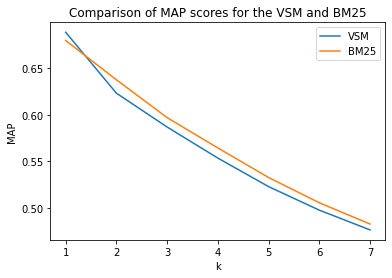

In [62]:
#@title MAP comparison visualization
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,8) ], [w[2] for w in r1], label = "VSM")
plt.plot([i for i in range(1,8) ], [w[2] for w in r2], label = "BM25")

plt.xlabel('k')
plt.ylabel('MAP')
plt.title('Comparison of MAP scores for the VSM and BM25')
plt.legend()
plt.show()

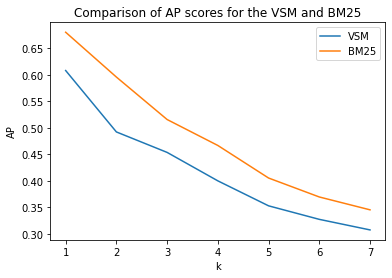

In [63]:
#@title Average Precision comparison visualization
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,8) ], [w[3] for w in r1], label = "VSM")
plt.plot([i for i in range(1,8) ], [w[3] for w in r2], label = "BM25")

plt.xlabel('k')
plt.ylabel('AP')
plt.title('Comparison of AP scores for the VSM and BM25')
plt.legend()
plt.show()

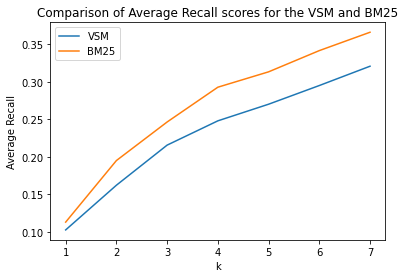

In [64]:
#@title Average Recall comparison visualization
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,8) ], [w[4] for w in r1], label = "VSM")
plt.plot([i for i in range(1,8) ], [w[4] for w in r2], label = "BM25")

plt.xlabel('k')
plt.ylabel('Average Recall')
plt.title('Comparison of Average Recall scores for the VSM and BM25')
plt.legend()
plt.show()

## Hypothesis Testing for 2 models

In [65]:
print('Hypothesis testing for BM25 vs VSM using AP metric')
d_x = [q[2] for q in r1[3][0]]
d_y = [q[2] for q in r2[3][0]]
test(d_x,d_y,0.05)

Hypothesis testing for BM25 vs VSM using AP metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.45625 y_:0.4699999999999999 sx :0.01183388157894737 sy: 0.010894736842105261 sp: 0.011364309210526315
Test statistic:  -0.40787884160855886
t-alpha:  1.685954457643814
p-value:  0.6571741631586483
alpha:  0.05
Conclusion: No evidence for proving new method is better


In [66]:
print('Hypothesis testing for BM25 vs VSM using Average Recall metric')
d_x = [q[3] for q in r1[3][0]]
d_y = [q[3] for q in r2[3][0]]
test(d_x,d_y,0.05)

Hypothesis testing for BM25 vs VSM using Average Recall metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.29228076656552826 y_:0.30188562985358114 sx :0.008283757156909804 sy: 0.00808946969840244 sp: 0.008186613427656121
Test statistic:  -0.3356904961251618
t-alpha:  1.685954457643814
p-value:  0.6305246495578102
alpha:  0.05
Conclusion: No evidence for proving new method is better


In [67]:
print('Hypothesis testing for BM25 vs VSM using MAP metric')
d_x = [q[0] for q in r1[3][0]]
d_y = [q[0] for q in r2[3][0]]
test(d_x,d_y,0.05)

Hypothesis testing for BM25 vs VSM using MAP metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.5540624999999999 y_:0.5695833333333332 sx :0.013892760873538013 sy: 0.015153691520467841 sp: 0.014523226197002926
Test statistic:  -0.40727099781431325
t-alpha:  1.685954457643814
p-value:  0.6569529022544536
alpha:  0.05
Conclusion: No evidence for proving new method is better


# Result of Lucene

In [68]:
path_res = '/content/drive/MyDrive/CS419.N11.KHCL/Final_Project/Lucene/output'

In [69]:
import os
tf_idf = os.path.join(path_res, 'TF-IDF.txt')
bm25 = os.path.join(path_res, 'BM25.txt')

In [70]:
def get_result_lucene(path):
  result = []
  with open(path, 'r') as f:
    res = f.readlines()
    for item in res:
      temp = item.split()
      result.append([temp[0],temp[2]])

  res_lucene = []
  k = 0     # k giúp duyệt mảng result không bị lặp lại
  for i in range(1,227):
    tmp = []
    for j in range(k,len(result)):
      if i == int(result[j][0]):
        tmp.append(result[j][1])
      else:
        k = j
        break
    res_lucene.append(tmp)

  res_convert = []
  for i in range(len(res_lucene)):
    res_convert.append([int(item) for item in res_lucene[i]])
  return res_convert

## tf_idf

In [71]:
res_tf_idf = get_result_lucene(tf_idf)

In [72]:
print(res_tf_idf[0])

[51, 486, 184, 13, 792, 875, 746, 12, 879, 747, 435, 1340, 359, 878, 141, 1268, 606, 876, 1328, 665, 252, 102, 874, 56, 1147, 240, 202, 663, 1144, 1111, 429, 584, 253, 315, 1361, 914, 29, 78, 1246, 92, 1250, 1149, 316, 378, 1155, 193, 817, 1163, 1380, 251, 880, 100, 280, 101, 1300, 1143, 1128, 707, 142, 204, 203, 540, 944, 800, 1305, 1362, 1389, 430, 1089, 552, 573, 1169, 168, 300, 95, 309, 1303, 1012, 799, 438, 909, 120, 1063, 436, 685, 391, 209, 566, 302, 571, 303, 945, 1263, 700, 285, 1050, 1315, 563, 593, 1003, 982, 62, 1124, 670, 52, 781, 311, 666, 962, 104, 911, 349, 1167, 925, 172, 24, 635, 497, 542, 883, 53, 160, 14, 686, 292, 564, 47, 1219, 643, 158, 406, 585, 776, 655, 399, 244, 1393, 283, 453, 549, 1098, 725, 82, 1168, 350, 1201, 1073, 1213, 717, 1042, 1002, 354, 638, 332, 546, 630, 1335, 431, 981, 374, 358, 810, 565, 711, 327, 294, 1314, 57, 973, 865, 991, 740, 11, 159, 687, 415, 963, 658, 493, 144, 1090, 485, 860, 1212, 976, 414, 80, 395, 1186, 1161, 441, 980, 219, 1140, 4

In [87]:
cal_map = Evaluate(evaluate_path, res_tf_idf, rank=True)
MAP_TFIDF = cal_map.MAP(interpolate=True)
niMAP_TFIDF = cal_map.MAP(interpolate=False)
print("Mean Average Precision Interpolation:\t", MAP_TFIDF)
print("Mean Average Precision Non_Interpolation:\t", niMAP_TFIDF)

Mean Average Precision Interpolation:	 0.4046704845666254
Mean Average Precision Non_Interpolation:	 0.3922476267321588


In [74]:
cal_recall_precision = Evaluate(evaluate_path, res_tf_idf, rank=False)
recall_TFIDF = cal_recall_precision.average(cal_recall_precision.recall)
print("Recall:\t", recall_TFIDF)
precision_TFIDF = cal_recall_precision.average(cal_recall_precision.precision)
print("Precision:\t", precision_TFIDF)

Recall:	 0.9675114965727328
Precision:	 0.007879531405975264


## BM25

In [75]:
res_bm25 = get_result_lucene(bm25)

In [76]:
print(res_bm25[0])

[51, 486, 184, 12, 13, 746, 792, 878, 573, 1268, 665, 141, 747, 1361, 875, 435, 879, 359, 1340, 14, 78, 663, 876, 1328, 944, 252, 1144, 56, 1003, 251, 29, 1147, 329, 606, 172, 315, 453, 202, 1263, 1246, 1300, 253, 914, 101, 36, 1128, 685, 280, 584, 219, 1163, 874, 240, 1072, 1380, 1155, 300, 1315, 717, 374, 311, 1335, 332, 1169, 526, 193, 378, 707, 540, 92, 1362, 880, 799, 102, 236, 781, 42, 817, 160, 588, 104, 729, 982, 204, 1305, 28, 95, 552, 1186, 309, 209, 542, 244, 293, 195, 283, 1089, 1143, 100, 1168, 302, 414, 168, 429, 25, 497, 316, 1149, 681, 800, 1111, 262, 635, 1012, 24, 53, 305, 495, 640, 142, 962, 1250, 82, 493, 456, 1167, 1194, 62, 1042, 638, 1219, 152, 563, 491, 292, 565, 925, 917, 52, 203, 1338, 629, 1213, 1063, 719, 349, 811, 220, 571, 1212, 911, 700, 858, 976, 572, 1303, 328, 630, 1034, 585, 294, 2, 658, 430, 522, 726, 120, 415, 991, 883, 1389, 1050, 1201, 395, 1101, 686, 284, 593, 1158, 431, 711, 481, 916, 216, 909, 406, 666, 285, 364, 1184, 80, 1244, 267, 373, 860, 

In [88]:
cal_map = Evaluate(evaluate_path, res_bm25, rank=True)
MAP_LCBM25 = cal_map.MAP(interpolate=True)
niMAP_LCBM25 = cal_map.MAP(interpolate=False)
print("Mean Average Precision Interpolation:\t", MAP_LCBM25)
print("Mean Average Precision Non_Interpolation:\t", niMAP_LCBM25)

Mean Average Precision Interpolation:	 0.44852678403569135
Mean Average Precision Non_Interpolation:	 0.4372632942138129


In [78]:
cal_recall_precision = Evaluate(evaluate_path, res_bm25, rank=False)
recall_LCBM25 = cal_recall_precision.average(cal_recall_precision.recall)
print("Recall:\t", recall_LCBM25)
precision_LCBM25 = cal_recall_precision.average(cal_recall_precision.precision)
print("Precision:\t", precision_LCBM25)

Recall:	 0.9749047420738428
Precision:	 0.00793730918375304


## Visualize comparison

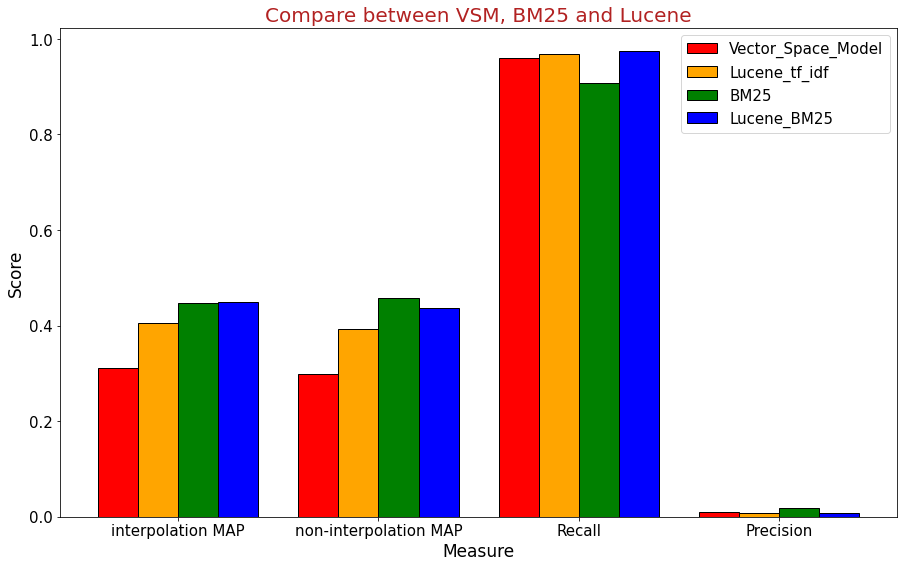

In [99]:
score = ['interpolation MAP', 'non-interpolation MAP', 'Recall', 'Precision']
Vector_Space_Model = [MAP_VSM, niMAP_VSM, recall_VSM, precision_VSM]
Lucene_tf_idf = [MAP_TFIDF, niMAP_TFIDF, recall_TFIDF, precision_TFIDF]
BM25 = [MAP_BM25, niMAP_BM25, recall_BM25, precision_BM25]
Lucene_BM25 = [MAP_LCBM25, niMAP_LCBM25, recall_LCBM25, precision_LCBM25]

blogs = pd.DataFrame({'score': score, 'Vector_Space_Model': Vector_Space_Model, 
                      'Lucene_tf_idf': Lucene_tf_idf, 'BM25': BM25, 'Lucene_BM25': Lucene_BM25})

# Visualizing the data with multiple bar chart
plt.figure(figsize=[15, 9])

# Set the width of the bars
wd = 0.4
x_pos = np.arange(1, 2*len(blogs), 2)

# Plotting the multiple bar graphs on the same figure
plt.bar(x_pos, blogs.Vector_Space_Model, color='r', width=wd, edgecolor='k',
        label='Vector_Space_Model')
plt.bar(x_pos+wd, blogs.Lucene_tf_idf, color='orange', width=wd, edgecolor='k', 
        label='Lucene_tf_idf')
plt.bar(x_pos+(wd*2), blogs.BM25, color='g', width=wd, 
        edgecolor='k', label='BM25')
plt.bar(x_pos+(wd*3), blogs.Lucene_BM25, color='b', width=wd, 
        edgecolor='k', label='Lucene_BM25')

# Add xticks
plt.xticks(x_pos+(wd*1.5), blogs.score.values, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Compare between VSM, BM25 and Lucene', fontsize=20, color='firebrick')
plt.xlabel('Measure', fontsize=17)
plt.ylabel('Score', fontsize=17)

plt.legend(loc='upper right', fontsize=15)
plt.show()